# Lunar Craters Detection using Deep Learning
> * 🔬 Data Science
> * 🥠 Deep Learning and image translation

## Table of Contents

* [Introduction](#Introduction)
* [Necessary imports](#Necessary-imports)
* [Connect to your GIS](#Connect-to-your-GIS)
* [Methodology](#Methodology)
* [Export training data](#Export-training-data)
* [Model training](#Model-training)
  * [Prepare data](#Prepare-data)
  * [Load MaskRCNN model architecture](#Load-Pix2Pix-model-architecture)
  * [Tuning for optimal learning rate](#Tuning-for-optimal-learning-rate)
  * [Fit the model](#Fit-the-model)
  * [Visualize results in validation set](#Visualize-results-in-validation-set)
  * [Save the model](#Save-the-model)
  * [Accuracy assessment](#Accuracy-assessment)
* [Model inferencing](#Model-inferencing)
* [Results visualization](#1)
* [Conclusion](#Conclusion)
* [References](#References)

## Introduction 

Crater detection and counting on moon plays an important role in the predicting moon's surface age when ground data is not available. Detection of craters also plays a vital role for safe landing site identification of lunar landers. Craters are also used as landmarks for navigation on the moon. Traditionally, craters are manually digitized using visual interpretation which is time taking and less effective. Deep learning is an upcoming technique which can be used as an alternate for manual digitization. This sample shows how ArcGIS API for Python can be used to train a deep learning model to detect lunar craters using DEM. The trained model can be deployed on ArcGIS Pro or ArcGIS Enterprise to detect craters.

## Necessary imports

In [1]:
import os
from pathlib import Path

from arcgis import GIS
from arcgis.learn import MaskRCNN, prepare_data

 ## Connect to your GIS

In [14]:
ent_gis = GIS('https://deldev.maps.arcgis.com/', 'demos_deldev', 'DelDevs.123')
gis = GIS('https://geosaurus.maps.arcgis.com/home', 'arcgis_python', 'amazing_arcgis_123')


In [6]:
gis = GIS('home')
ent_gis = GIS('https://pythonapi.playground.esri.com/portal', 'arcgis_python', 'amazing_arcgis_123')

## Export training data

Digital Elevation Model (DEM) of moon will be used as `input_raster` for the training data. The spatial resolution DEM is 118m and the DEM can be downloaded from the USGS website from [here](https://astrogeology.usgs.gov/search/map/Moon/LRO/LOLA/Lunar_LRO_LOLAKaguya_DEMmerge_60N60S_512ppd).

In [79]:
lunar_dem = ent_gis.content.get('e3e4067072ef4980b92825f494dc8ac7')
lunar_dem

<Item title:"dem_training_raster" type:Imagery Layer owner:api_data_owner>

The feature layers for craters will be used as the `Input Feature Class` for the training data.

<Item title:"craters_diameter_more_than_20km" type:Feature Layer Collection owner:demos_deldev>
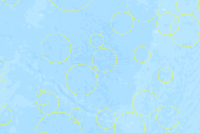

In [76]:
craters_more_than_20km = gis.content.get('36272e93ec4547abba495c797a4fb921')
craters_more_than_20km

<Item title:"craters_diameter_5_20km" type:Feature Layer Collection owner:demos_deldev>
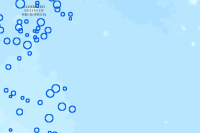

In [78]:
craters_5_20km = gis.content.get('af240e45a3ca445b88d6ec19209d3bb5')
craters_5_20km

## Methodology

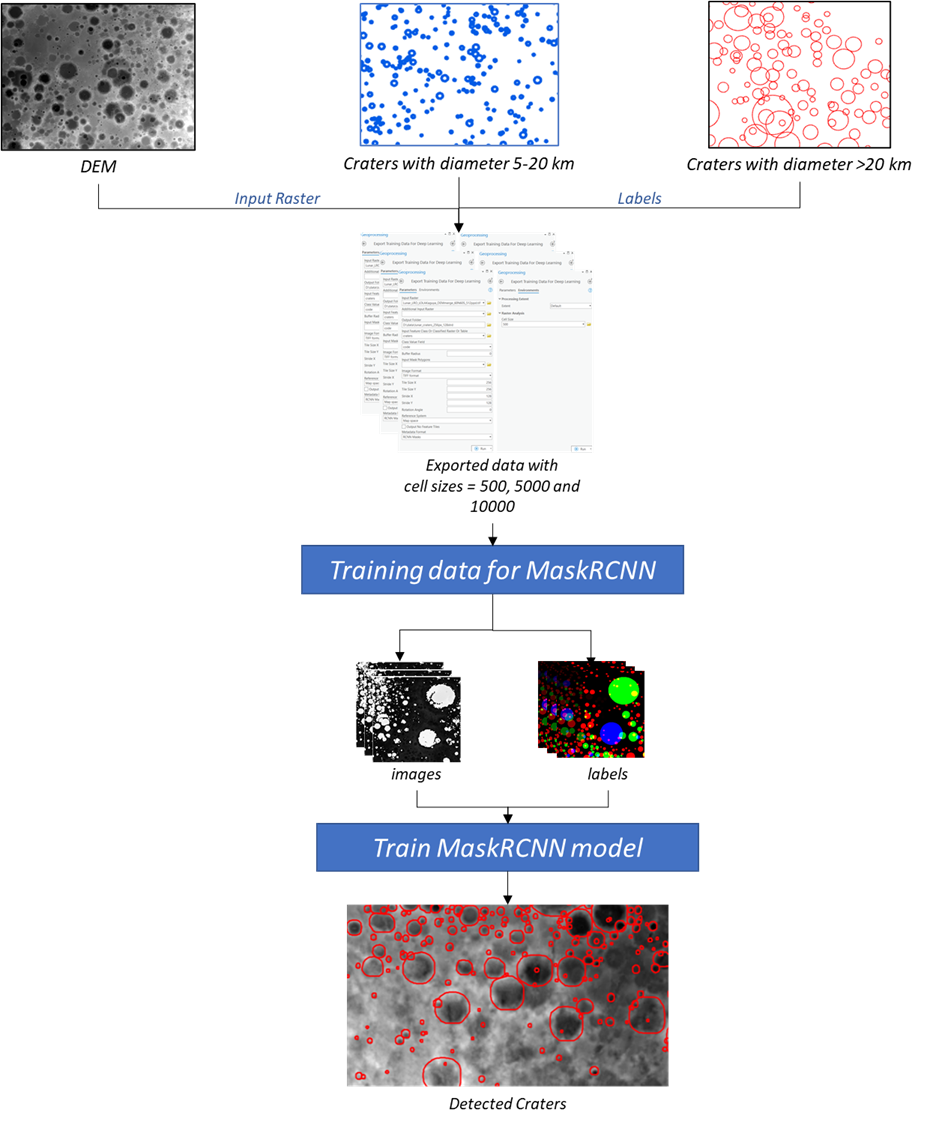

The data will be exported in “Export_Tiles” metadata format which is available in the [Export Training Data For Deep Learning](https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/export-training-data-for-deep-learning.htm) tool. This tool is available in [ArcGIS Pro](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview) as well as [ArcGIS Image Server](https://www.esri.com/en-us/arcgis/products/arcgis-image-server). The various inputs required by the tool, are described below.

- `Input Raster`: Lunar DEM

- `Input Feature Class Or Classified Raster Or Table`: craters feature layer 

- `Tile Size X & Tile Size Y`: 256

- `Stride X & Stride Y`: 128

- `Meta Data Format`: 'RCNN Masks' as we are training a `MaskRCNN` model.

- *`Environments`*: 
  - `Cell Size`: The data is exported on 3 different cellsizes so that it can learn to detect craters of different diameters. The data is exported on 500, 5000 and 1000. 
  - `Processing Extent`: Default.

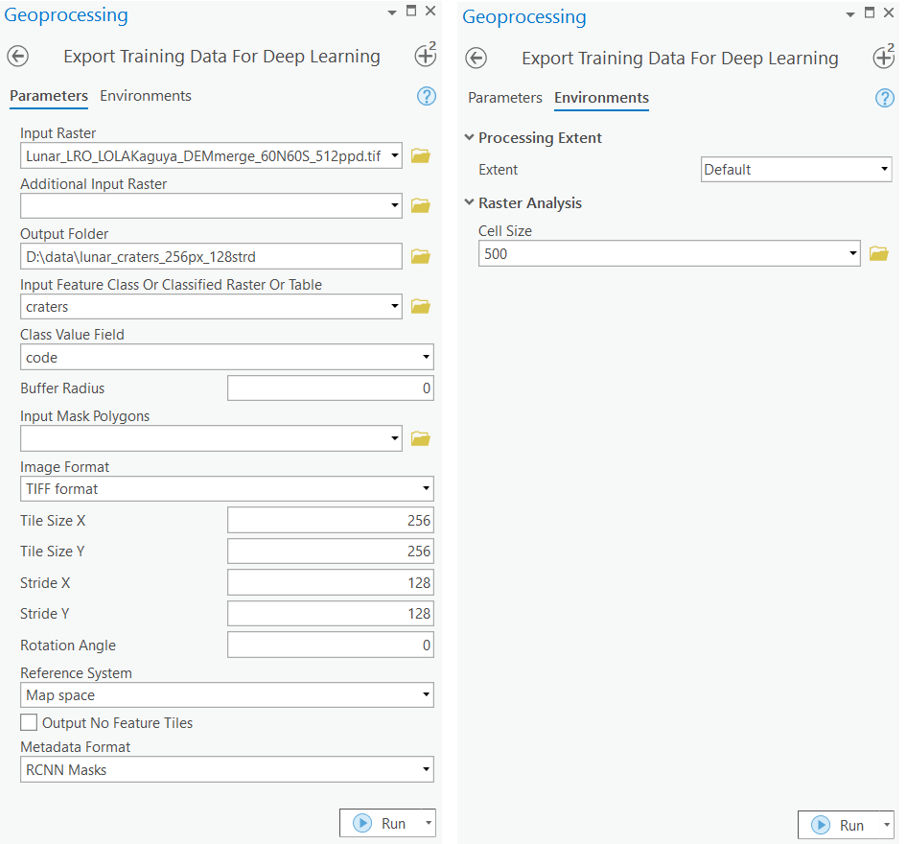

Inside the exported data folder, 'images' folder contains all the chips of DEM and 'labels' folder contains masks of craters.

## Model training

Alternatively, we have provided a subset of training data containing a few samples that follows the same directory structure mentioned above and also provided the raster and crater feature layer used for exporting the training dataset. The provided data can be used directly to run the experiments.

<Item title:"lunar_craters_detection_from_digital_elevation_models_using_deep_learning" type:Image Collection owner:api_data_owner>
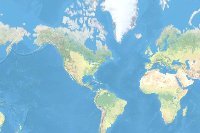

In [5]:
training_data = gis.content.get('0a4e2d4ad7bf41f6973c7e3434faf7d4')
training_data

In [6]:
filepath = training_data.download(file_name=training_data.name)

In [7]:
#Extract the data from the zipped image collection
import zipfile
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

### Prepare data

In [8]:
output_path = Path(os.path.join(os.path.splitext(filepath)[0]))

In [6]:
data = prepare_data(output_path, batch_size=8)

In [7]:
data

ImageDataBunch;

Train: LabelList (357 items)
x: ArcGISInstanceSegmentationItemList
ArcGISMSImage (1, 224, 224),ArcGISMSImage (1, 224, 224),ArcGISMSImage (1, 224, 224),ArcGISMSImage (1, 224, 224),ArcGISMSImage (1, 224, 224)
y: ArcGISSegmentationLabelList
ArcGISImageSegment (1, 224, 224),ArcGISImageSegment (1, 224, 224),ArcGISImageSegment (1, 224, 224),ArcGISImageSegment (1, 224, 224),ArcGISImageSegment (1, 224, 224)
Path: C:\data\2021\lunar\moon_mrcnn_256px_128strd_multicellsize1\moon_mrcnn_256px_128strd_multicellsize1\images;

Valid: LabelList (39 items)
x: ArcGISInstanceSegmentationItemList
ArcGISMSImage (1, 224, 224),ArcGISMSImage (1, 224, 224),ArcGISMSImage (1, 224, 224),ArcGISMSImage (1, 224, 224),ArcGISMSImage (1, 224, 224)
y: ArcGISSegmentationLabelList
ArcGISImageSegment (1, 224, 224),ArcGISImageSegment (1, 224, 224),ArcGISImageSegment (1, 224, 224),ArcGISImageSegment (1, 224, 224),ArcGISImageSegment (1, 224, 224)
Path: C:\data\2021\lunar\moon_mrcnn_256px_128strd_multicellsize1

### Visualize a few samples from your training data

To get a sense of what the training data looks like, `arcgis.learn.show_batch()` method randomly picks a few training chips and visualize them.

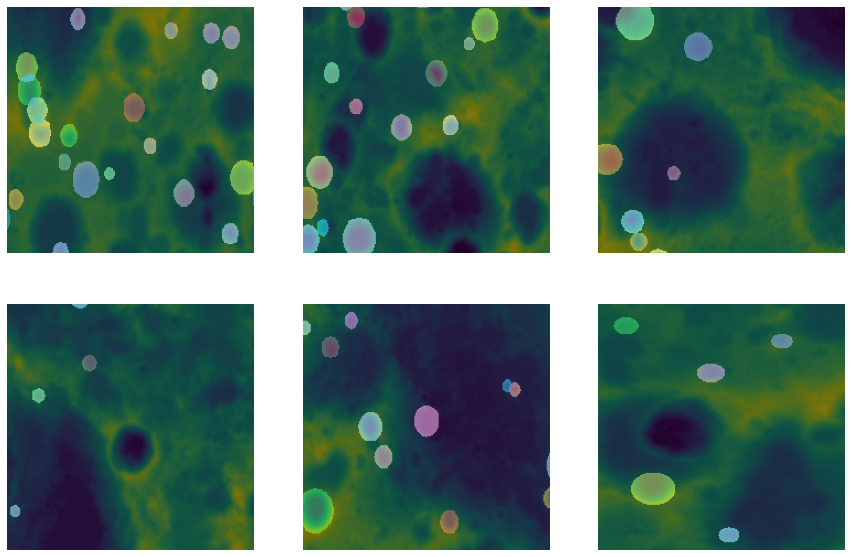

In [28]:
data.show_batch(rows=2)

### Load model architecture

`arcgis.learn` provides the MaskRCNN model for instance segmentation tasks, which is based on a pretrained convnet, like ResNet that acts as the 'backbone'. More details about MaskRCNN can be found [here](https://developers.arcgis.com/python/guide/how-maskrcnn-works/).

In [11]:
model = MaskRCNN(data)

### Tuning for optimal learning rate

Learning rate is one of the most important hyperparameters in model training. ArcGIS API for Python provides a learning rate finder that automatically chooses the optimal learning rate for you.

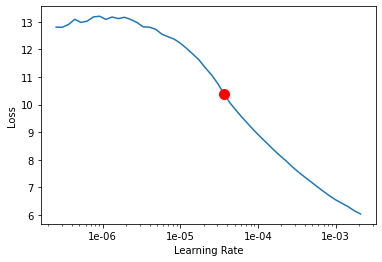

3.630780547701014e-05

In [12]:
lr = model.lr_find()
lr

### Fit the model

The model is trained for around a few epochs with the `early_stopping=True` and suggested learning rate.

In [13]:
model.fit(100, lr, early_stopping=True)

epoch,train_loss,valid_loss,time
0,6.944399,5.095363,01:00
1,3.083338,2.410944,01:04
2,2.264618,2.287425,01:08
3,2.102938,2.249945,01:09
4,2.032436,2.229557,01:15
5,2.009923,2.240452,01:15
6,1.982428,2.191599,01:12
7,1.960892,2.277536,01:17
8,1.991066,2.217761,01:17
9,1.938140,2.132267,01:17


Epoch 56: early stopping


Here, the model training automatically stopped at 56th epoch, we can see reasonable results — both training and validation losses have gone down considerably, indicating that the model is learning to translate between domain of imageries.

### Save the model

We will save the model which we trained as a 'Deep Learning Package' ('.dlpk' format). Deep Learning package is the standard format used to deploy deep learning models on the ArcGIS platform. 

We will use the save() method to save the trained model. By default, it will be saved to the 'models' sub-folder within our training data folder.

In [15]:
model.save("craters_mrcnn_56e"), publish=True)

Computing model metrics...


WindowsPath('C:/data/2021/lunar/moon_mrcnn_256px_128strd_multicellsize1/moon_mrcnn_256px_128strd_multicellsize1/models/craters_mrcnn_56e')

### Visualize results in validation set

It is a good practice to see results of the model viz-a-viz ground truth. The model.show_results() method can be used to display the detected building footprints. Each detection is visualized as a mask by default.

In [ ]:
model.show_results(rows=3, mask_threshold=0.7)

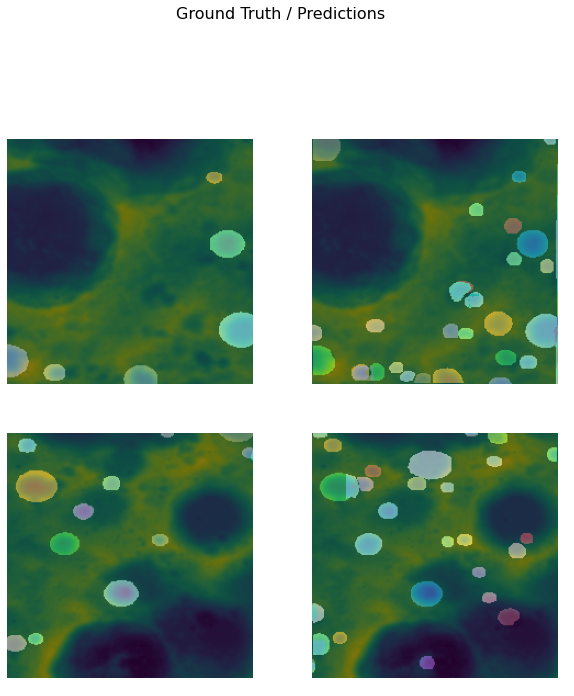

### Accuracy assessment

We can compute the average precision score for the model we just trained in order to do the accuracy assessment. Average precision computes average precision on the validation set for each class. We can compute the Average Precision Score by calling `model.average_precision_score`. It takes the following parameters:

- `detect_thresh`: The probability above which a detection will be considered for computing average precision.
- `iou_thresh`: The intersection over union threshold with the ground truth labels, above which a predicted bounding box will be considered a true positive.
- `mean`: If False, returns class-wise average precision otherwise returns mean average precision.

In [17]:
model.average_precision_score()

{'1': 0.4536149187175708}

## Model inferencing

After we trained the `MaskRCNN` model and saved the weights for detect craters masks using the [Detect Objects Using Deep Learning](https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/detect-objects-using-deep-learning.htm) tool available in [ArcGIS Pro](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview), or [ArcGIS Image Server](https://www.esri.com/en-us/arcgis/products/arcgis-image/options/arcgis-image-server?rsource=https%3A%2F%2Fwww.esri.com%2Fen-us%2Farcgis%2Fproducts%2Farcgis-image-server).

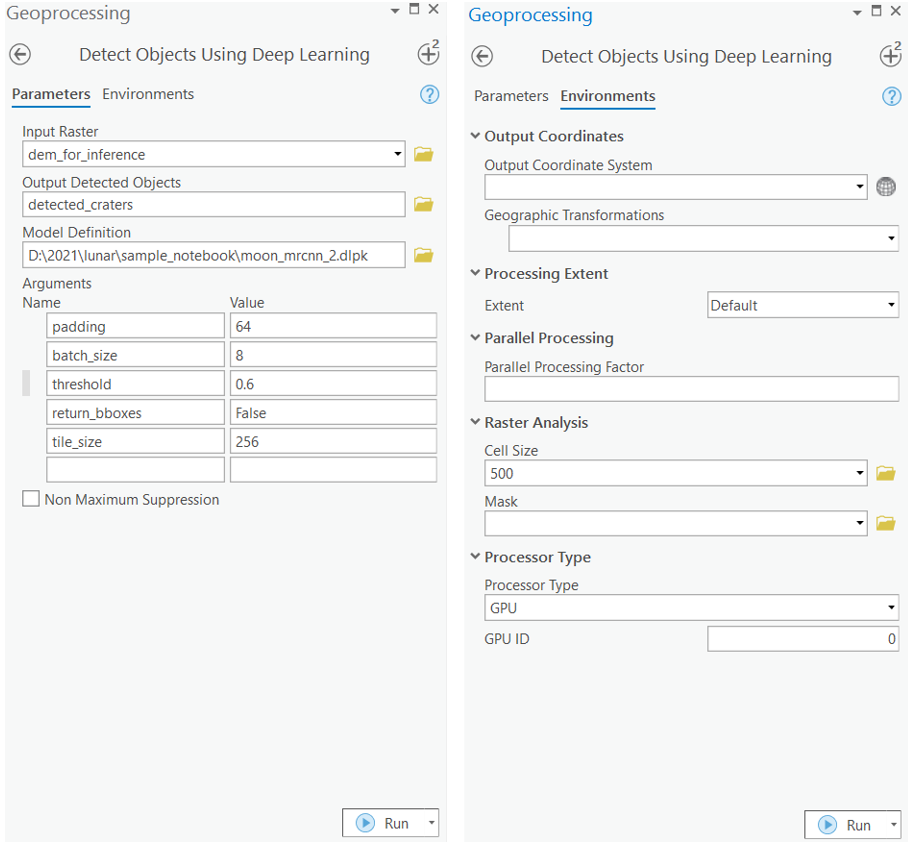

`arcpy.ia.DetectObjectsUsingDeepLearning(in_raster="dem_for_inference",
out_detected_objects=r"\\detected_craters",
in_model_definition=r"\\models\moon_mrcnn_2\moon_mrcnn_2.dlpk",
model_arguments ="padding 56;batch_size 4;threshold 0.6;return_bboxes False",
run_nms="NMS",
confidence_score_field="Confidence",
class_value_field="Class",
max_overlap_ratio=0,
processing_mode="PROCESS_AS_MOSAICKED_IMAGE")`

The inferencing was done on different cell sizes i.e. 500m (small craters), 5000(medium size craters) and 10,000m (large craters). All the inferenced outputs were merged together to get the final feature layer which consists all craters.

## Results visualization<a class="anchor" id="1"></a>

The craters are detected on two areas using ArcGIS Pro. The results are published on the portal for visualization. 

In [18]:
area1_ras = gis.content.get('76e646b550134fcc9cf5d5496cc13c2e')
area2_ras = gis.content.get('d08e316ced3b418fbd5e58a4fb1166b3')

In [27]:
area1_craters = gis.content.get('2d28ca3fc90349f094d5d12886133506')
area2_craters = gis.content.get('63430aa4d4e04c748f7e9314bccd1d93')

### Create map widgets
Two map widgets are created showing DEM and inferenced craters. 

In [42]:
## Area1 Craters
map1 = ent_gis.map()
map1.add_layer(area1_ras.layers[0])
map1.add_layer(area1_craters)

## Area2 Craters
map2 = ent_gis.map()
map2.add_layer(area2_ras.layers[0])
map2.add_layer(area2_craters)

### Set the map layout

In [43]:
from ipywidgets import HBox, VBox, Label, Layout

[Hbox and Vbox](https://developers.arcgis.com/python/api-reference/arcgis.widgets.html?highlight=hbox) were used to set the layout of map widgets.

In [44]:
hbox_layout = Layout()
hbox_layout.justify_content = 'space-around'

hb1,hb2=HBox([Label('Area 1')]),\
            HBox([Label('Area 2')])
hb1.layout,hb2.layout=hbox_layout,hbox_layout

### Results

The predictions are provided as a map for better visualization.

In [47]:
VBox([hb1,HBox([map1]),hb2,HBox([map2])])

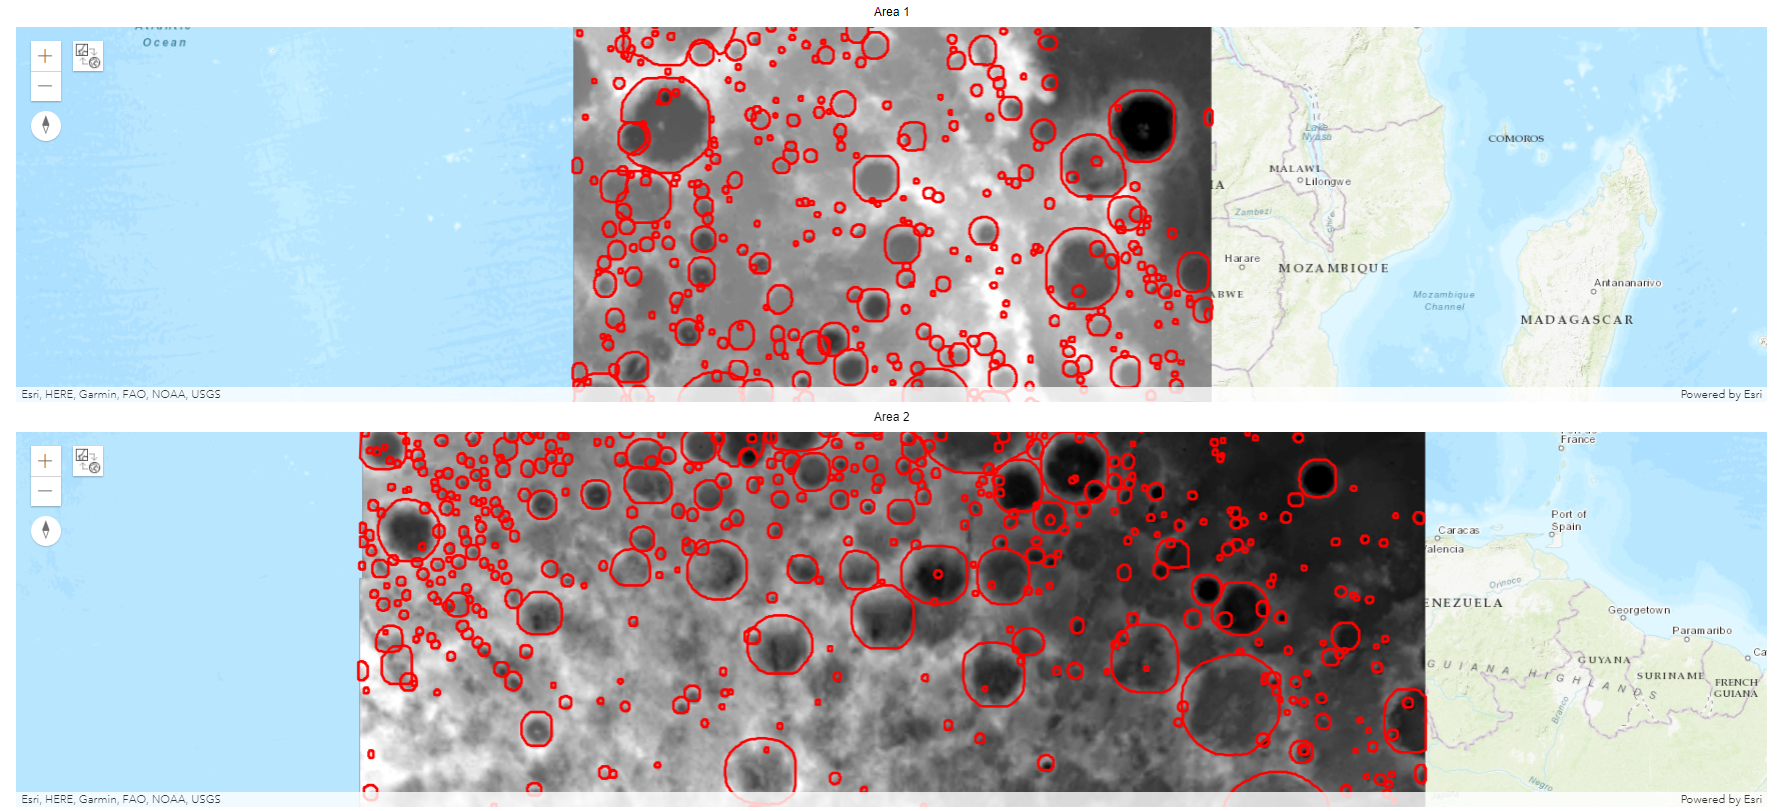

In [46]:
map1.zoom_to_layer(area1_ras)
map2.zoom_to_layer(area2_ras)

In the above maps it can be seen that the trained MaskRCNN model is able to detect craters of different sizes very accurately. The training data has features as circles but the model also learned to detect accurate boundaries of craters.

## Conclusion

This notebook showcased how instance segmentation models like MaskRCNN can be used to automatically detect lunar craters using DEM. This notebook also showcased how custom transformations, irrespective of already present standard transformations, based on the data, can be added while preparing data in order to achieve better performance.